In [1]:
from scipy.stats import chi2, expon, weibull_min
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer
from sklearn.model_selection import train_test_split
from copy import deepcopy

import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

import nflows
from nflows import flows, transforms
from nflows.flows.base import Flow
from nflows.distributions.normal import ConditionalDiagonalNormal
from nflows.transforms.base import CompositeTransform
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms.permutations import ReversePermutation
from nflows.nn.nets import ResidualNet

np.random.seed(100)
print(torch.cuda.is_available())

True


In [2]:
print(torch.cuda.current_device())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

0
cuda


In [3]:
class MyDataset(Dataset):
    def __init__(
        self,
        dataframe,
        context_variables,
        target_variables,
        device=None,
        rows=None,
    ):
        self.context_variables = context_variables
        self.target_variables = target_variables
        self.all_variables = context_variables + target_variables
        data = dataframe
        if rows is not None:
            data = data.iloc[:rows]
        self.target = data[target_variables].values
        self.context = data[context_variables].values
        if device is not None:
            self.target = torch.tensor(self.target, dtype=torch.float32).to(device)
            self.context = torch.tensor(self.context, dtype=torch.float32).to(device)

    def __len__(self):
        assert len(self.context) == len(self.target)
        return len(self.target)

    def __getitem__(self, idx):
        return self.context[idx], self.target[idx]

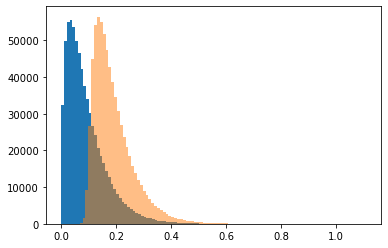

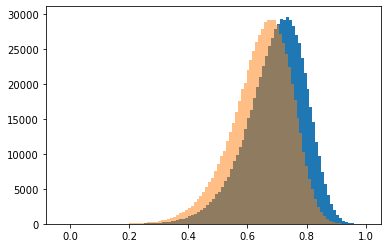

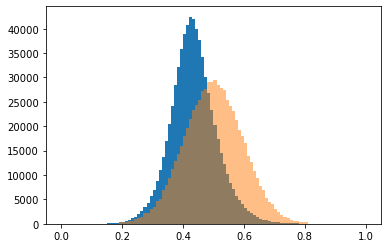

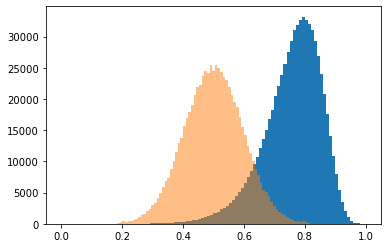

[0.00245433 0.03603637 0.09510187 ... 0.04894838 0.01570462 0.04753358]


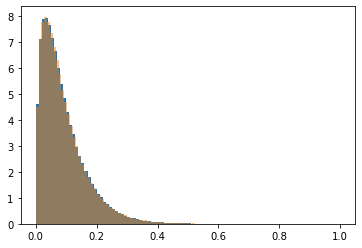

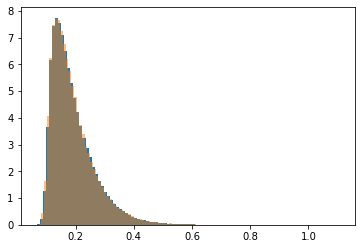

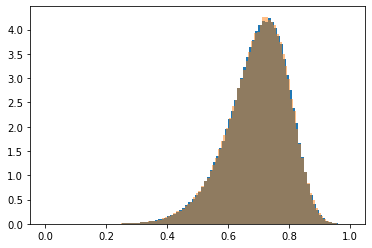

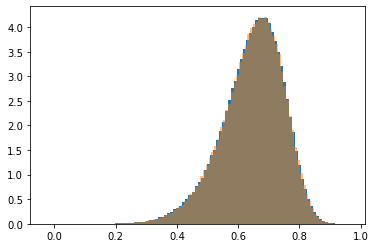

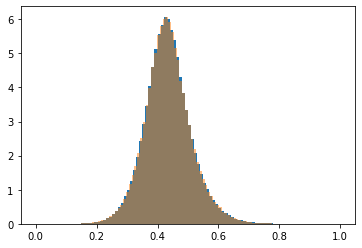

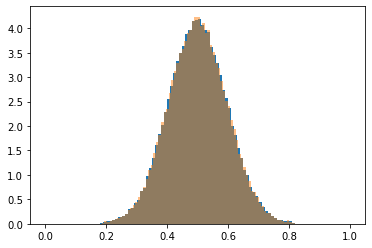

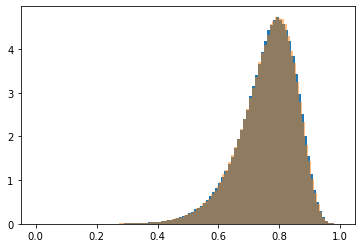

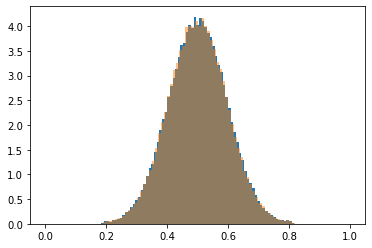

In [4]:
nevs = 1000000
dof = 3
pdf1 = chi2(dof)
sample1 = pdf1.rvs(nevs)
sample1 = MinMaxScaler((0, 1)).fit_transform(sample1.reshape(-1, 1)).reshape(-1)
sample1_target = sample1 + 0.1 + 0.01 * np.random.normal(size=sample1.shape)
#sample1_target = deepcopy(sample1)
sample1_train, sample1_test = train_test_split(sample1, test_size=0.3)
sample1_target_train, sample1_target_test = train_test_split(sample1_target, test_size=0.3)
plt.hist(sample1_train, bins=100)
plt.hist(sample1_target_train, bins=100, alpha=0.5)
plt.show()

pdf2 = weibull_min(10, 1)
sample2 = pdf2.rvs(nevs)
sample2 = MinMaxScaler((0, 1)).fit_transform(sample2.reshape(-1, 1)).reshape(-1)
sample2_target = sample2 - 0.05 + 0.01 * np.random.normal(size=sample2.shape)
#sample2_target = deepcopy(sample2)
sample2_train, sample2_test = train_test_split(sample2, test_size=0.3)
sample2_target_train, sample2_target_test = train_test_split(sample2_target, test_size=0.3)
plt.hist(sample2_train, bins=100)
plt.hist(sample2_target_train, bins=100, alpha=0.5)
plt.show()

# now produce three samples that are related to both pdf1, pdf2 and each other
sample3 = np.log1p(sample1) + np.log1p(sample2)
sample3 = MinMaxScaler((0, 1)).fit_transform(sample3.reshape(-1, 1)).reshape(-1)
sample3_target = np.log1p(sample1_target) + np.log1p(sample2_target)
sample3_target = QuantileTransformer(output_distribution='normal').fit_transform(sample3_target.reshape(-1, 1)).reshape(-1)
sample3_target = MinMaxScaler((0, 1)).fit_transform(sample3_target.reshape(-1, 1)).reshape(-1)
sample3_train, sample3_test = train_test_split(sample3, test_size=0.3)
sample3_target_train, sample3_target_test = train_test_split(sample3_target, test_size=0.3)
plt.hist(sample3_train, bins=100)
plt.hist(sample3_target_train, bins=100, alpha=0.5)
plt.show()

sample4 = np.log1p(sample1) + np.log1p(sample2) - np.log1p(sample1 * sample2) + 0.05
sample4 = MinMaxScaler((0, 1)).fit_transform(sample4.reshape(-1, 1)).reshape(-1)
sample4_target = np.log1p(sample1_target) + np.log1p(sample2_target) - np.log1p(sample1_target * sample2_target) + 0.05
sample4_target = QuantileTransformer(output_distribution='normal').fit_transform(sample4_target.reshape(-1, 1)).reshape(-1)
sample4_target = MinMaxScaler((0, 1)).fit_transform(sample4_target.reshape(-1, 1)).reshape(-1)
sample4_train, sample4_test = train_test_split(sample4, test_size=0.3)
sample4_target_train, sample4_target_test = train_test_split(sample4_target, test_size=0.3)
plt.hist(sample4_train, bins=100)
plt.hist(sample4_target_train, bins=100, alpha=0.5)
plt.show()

print(sample1_train)
df = pd.DataFrame({'a': sample1_train, 'b': sample2_train, 'x': sample3_train, 'y': sample4_train})
df_target = pd.DataFrame({'a': sample1_target_train, 'b': sample2_target_train, 'x': sample3_target_train, 'y': sample4_target_train})

df_test = pd.DataFrame({'a': sample1_test, 'b': sample2_test, 'x': sample3_test, 'y': sample4_test})
df_target_test = pd.DataFrame({'a': sample1_target_test, 'b': sample2_target_test, 'x': sample3_target_test, 'y': sample4_target_test})

plt.hist(df['a'], bins=100, density=True)
plt.hist(df_test['a'], bins=100, density=True, alpha=0.5)
plt.show()
plt.hist(df_target['a'], bins=100, density=True)
plt.hist(df_target_test['a'], bins=100, density=True, alpha=0.5)
plt.show()
plt.hist(df['b'], bins=100, density=True)
plt.hist(df_test['b'], bins=100, density=True, alpha=0.5)
plt.show()
plt.hist(df_target['b'], bins=100, density=True)
plt.hist(df_target_test['b'], bins=100, density=True, alpha=0.5)
plt.show()
plt.hist(df['x'], bins=100, density=True)
plt.hist(df_test['x'], bins=100, density=True, alpha=0.5)
plt.show()
plt.hist(df_target['x'], bins=100, density=True)
plt.hist(df_target_test['x'], bins=100, density=True, alpha=0.5)
plt.show()
plt.hist(df['y'], bins=100, density=True)
plt.hist(df_test['y'], bins=100, density=True, alpha=0.5)
plt.show()
plt.hist(df_target['y'], bins=100, density=True)
plt.hist(df_target_test['y'], bins=100, density=True, alpha=0.5)
plt.show()

In [5]:
df['lab'] = 1
df_test['lab'] = 1
df_target['lab'] = 0
df_target_test['lab'] = 0

In [6]:
new_df_train = pd.concat([df, df_target])
new_df_train = new_df_train.reset_index(drop=True)
new_df_train = new_df_train.sample(frac=1).reset_index(drop=True)
new_df_test = pd.concat([df_test, df_target_test])
new_df_test = new_df_test.reset_index(drop=True)
new_df_test = new_df_test.sample(frac=1).reset_index(drop=True)

In [7]:
context_vars = ['a', 'b', 'lab']
input_vars = ['x', 'y']
rows = 100000
rows_test = 100000
batch_size = 1000
print(len(new_df_train), len(new_df_test))

new_dataset_train = MyDataset(new_df_train, context_vars, input_vars, device=device, rows=rows)
new_loader_train = DataLoader(new_dataset_train, batch_size=batch_size)
new_dataset_test = MyDataset(new_df_test, context_vars, input_vars, device=device, rows=rows)
new_loader_test = DataLoader(new_dataset_test, batch_size=batch_size)

1400000 600000


In [8]:
ninput = 2
ncontext = 3

epochs = 100
plot_every = 10

def spline_inn(
    inp_dim,
    nodes=128,
    num_blocks=2,
    num_stack=3,
    tail_bound=3.5,
    tails="linear",
    activation=F.relu,
    lu=0,
    num_bins=12,
    context_features=None,
    dropout_probability=0.0,
    flow_for_flow=False,
):
    transform_list = []
    for i in range(num_stack):
        transform_list += [
            transforms.MaskedPiecewiseRationalQuadraticAutoregressiveTransform(
                inp_dim,
                nodes,
                num_blocks=num_blocks,
                tail_bound=tail_bound,
                num_bins=num_bins,
                tails=tails,
                activation=activation,
                dropout_probability=dropout_probability,
                context_features=context_features,
            )
        ]
        if lu:
            transform_list += [transforms.LULinear(inp_dim)]
        else:
            transform_list += [transforms.ReversePermutation(inp_dim)]

    if not (flow_for_flow and (num_stack % 2 == 0)):
        # If the above conditions are satisfied then you want to permute back to the original ordering such that the
        # output features line up with their original ordering.
        transform_list = transform_list[:-1]

    return transforms.CompositeTransform(transform_list)

def get_conditional_base_flow(
    input_dim,
    context_dim,
    nstack,
    nnodes,
    nblocks,
    tail_bound,
    nbins,
    activation,
    dropout_probability,
):
    flow = Flow(
        spline_inn(
            input_dim,
            nodes=nnodes,
            num_blocks=nblocks,
            num_stack=nstack,
            tail_bound=tail_bound,
            activation=getattr(F, activation),
            dropout_probability=dropout_probability,
            num_bins=nbins,
            context_features=context_dim,
        ),
        ConditionalDiagonalNormal(
            shape=[input_dim], context_encoder=nn.Linear(context_dim, 2 * input_dim)
        ),
    )

    return flow

def make_flow_and_train(loader, test_loader, df_test):
    flow = get_conditional_base_flow(
        input_dim=ninput,
        context_dim=ncontext,
        nstack=2,
        nnodes=8,
        nblocks=4,
        tail_bound=1.0,
        nbins=10,
        activation="relu",
        dropout_probability=0.1,
    )
    flow = flow.to(device)
    optimizer = optim.Adam(flow.parameters())

    train_history, test_history = [], []
    for epoch in range(epochs + 1):
        print(epoch)
        train_losses, test_losses = [], []

        # train
        for abl, xy in loader:
            loss = -flow.log_prob(inputs=xy, context=abl).mean()
            train_losses.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        epoch_train_loss = np.mean(train_losses)
        train_history.append(epoch_train_loss)

        # test
        print('testing')
        for abl, xy in test_loader:
            with torch.no_grad():
                loss = -flow.log_prob(inputs=xy, context=abl).mean()
                test_losses.append(loss.item())
        
        epoch_test_loss = np.mean(test_losses)
        test_history.append(epoch_test_loss)

        if epoch % plot_every == 0:
            print("plotting")
            fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
            a, b, l, x, y = df_test['a'].values, df_test['b'].values, df_test['lab'], df_test['x'].values, df_test['y'].values
            xy_sample = flow.sample(1, context=torch.tensor(df_test[['a', 'b', 'lab']].values, dtype=torch.float32).to(device)).reshape(-1, ninput)
            x_sample = xy_sample[:, 0].detach().cpu().numpy()
            y_sample = xy_sample[:, 1].detach().cpu().numpy()
            x_min = min(x.min(), x_sample.min())
            x_max = max(x.max(), x_sample.max())
            ax1.hist(x, bins=100, range=(x_min, x_max), density=True, alpha=0.5, label='sample');
            ax1.hist(x_sample, bins=100, range=(x_min, x_max), density=True, alpha=0.5, label='flow');
            y_min = min(y.min(), y_sample.min())
            y_max = max(y.max(), y_sample.max())
            ax1.legend()
            ax2.hist(y, bins=100, range=(y_min, y_max), density=True, alpha=0.5, label='sample');
            ax2.hist(y_sample, bins=100, range=(y_min, y_max), density=True, alpha=0.5, label='flow');
            ax2.legend()
            # plot loss
            ax3.plot(train_history, label='train')
            ax3.plot(test_history, label='test')
            ax3.legend()
            plt.show()
    
    return flow

0
testing
plotting


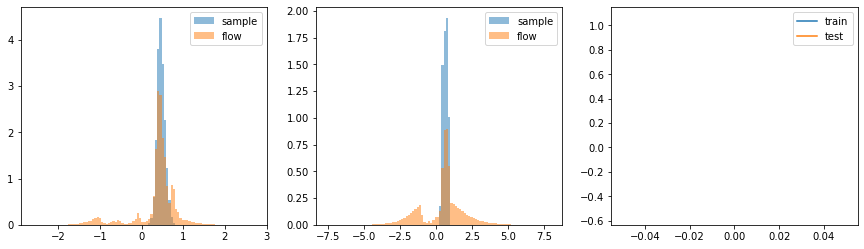

1
testing
2
testing
3
testing
4
testing
5
testing
6
testing
7
testing
8
testing
9
testing
10
testing
plotting


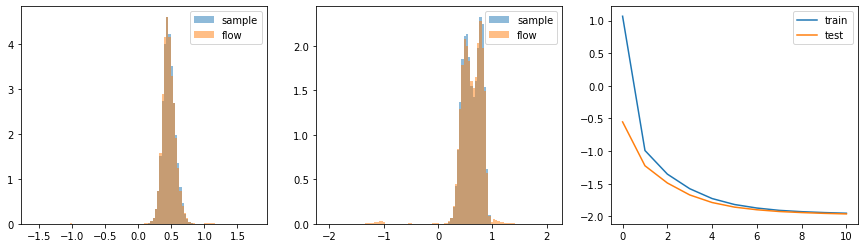

11
testing
12
testing
13
testing
14
testing
15
testing
16
testing
17
testing
18
testing
19
testing
20
testing
plotting


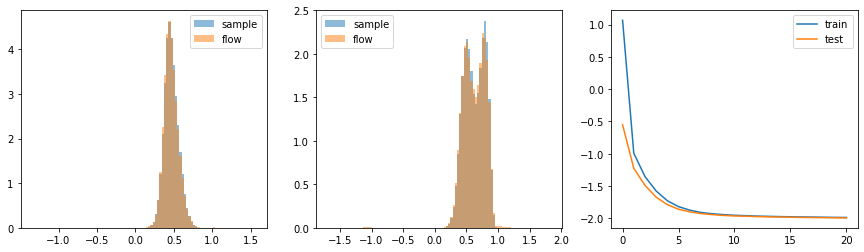

21
testing
22
testing
23
testing
24
testing
25
testing
26
testing
27
testing
28
testing
29
testing
30
testing
plotting


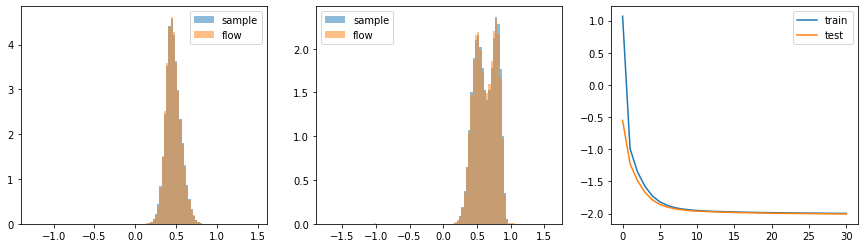

31
testing
32
testing
33
testing
34
testing
35
testing
36
testing
37
testing
38
testing
39
testing
40
testing
plotting


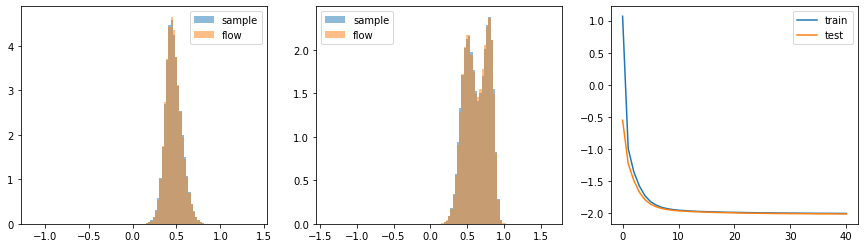

41
testing
42
testing
43
testing
44
testing
45
testing
46
testing
47
testing
48
testing
49
testing
50
testing
plotting


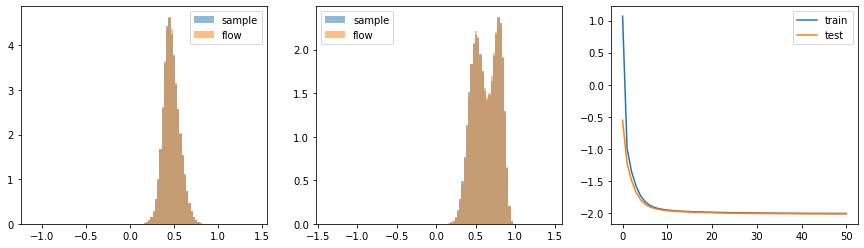

51
testing
52
testing
53
testing
54
testing
55
testing
56
testing
57
testing
58
testing
59
testing
60
testing
plotting


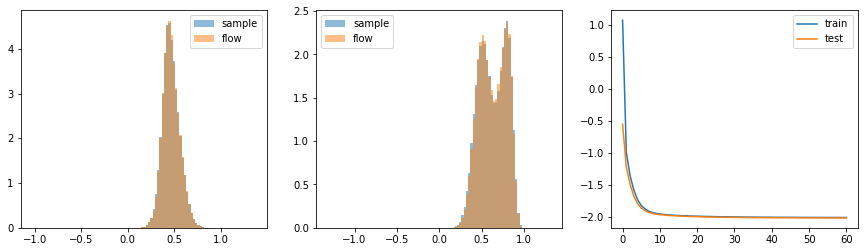

61
testing
62
testing
63
testing
64
testing
65
testing
66
testing
67
testing
68
testing
69
testing
70
testing
plotting


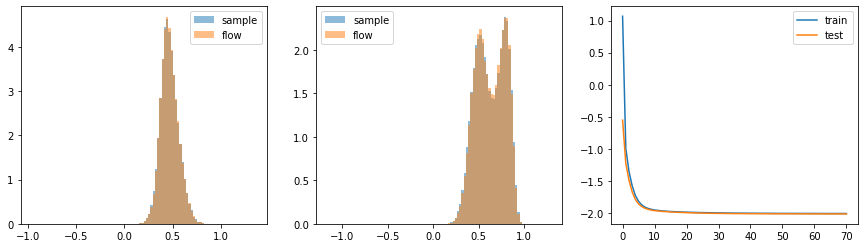

71
testing
72
testing
73
testing
74
testing
75
testing
76
testing
77
testing
78
testing
79
testing
80
testing
plotting


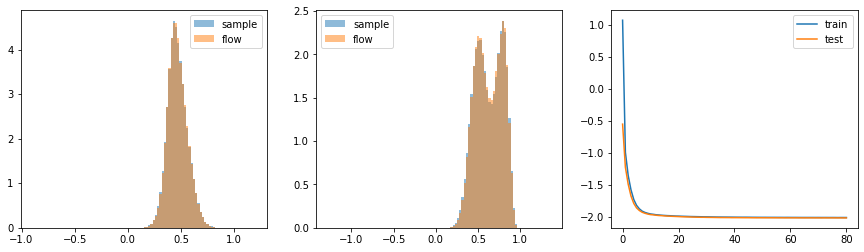

81
testing
82
testing
83
testing
84
testing
85
testing
86
testing
87
testing
88
testing
89
testing
90
testing
plotting


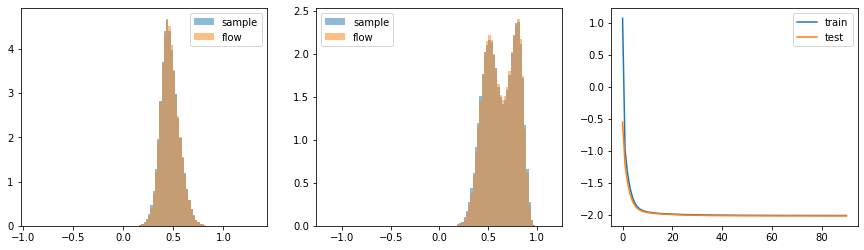

91
testing
92
testing
93
testing
94
testing
95
testing
96
testing
97
testing
98
testing
99
testing
100
testing
plotting


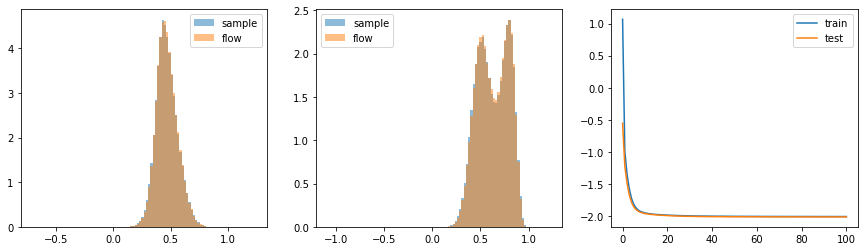

In [9]:
flow = make_flow_and_train(new_loader_train, new_loader_test, new_df_test)

## Apply it

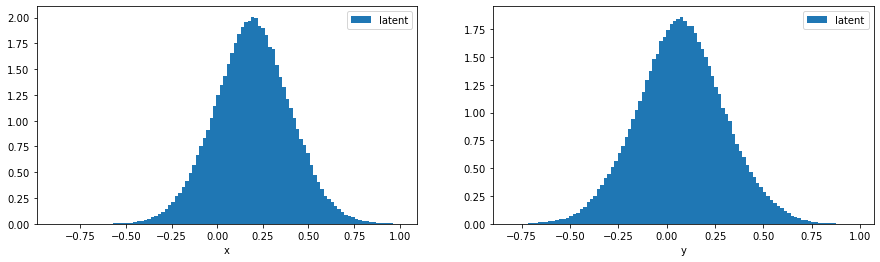

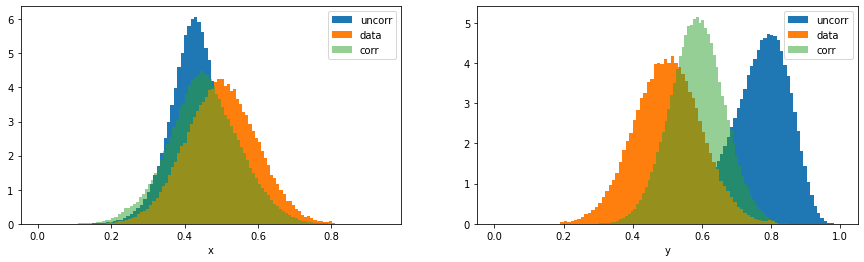

In [10]:
def apply(flow, df_mc, df_data):
    abl = torch.tensor(df_mc[['a', 'b', 'lab']].values, dtype=torch.float32).to(device)
    xy_uncorr = torch.tensor(df_mc[['x', 'y']].values, dtype=torch.float32).to(device)
    xy_uncorr_latent = flow._transform(xy_uncorr, abl)[0]
    x_uncorr_latent, y_uncorr_latent = xy_uncorr_latent[:, 0].detach().cpu().numpy(), xy_uncorr_latent[:, 1].detach().cpu().numpy()
    x_uncorr, y_uncorr = xy_uncorr[:, 0].detach().cpu().numpy(), xy_uncorr[:, 1].detach().cpu().numpy()
    
    # second part of transformation
    zeros = torch.zeros(xy_uncorr_latent.shape[0], 1).to(device)
    ab = torch.tensor(df_mc[['a', 'b']].values, dtype=torch.float32).to(device)
    abl = torch.cat((ab, zeros), axis=1)
    xy_corr = flow._transform.inverse(xy_uncorr_latent, abl)[0]
    x_corr, y_corr = xy_corr[:, 0].detach().cpu().numpy(), xy_corr[:, 1].detach().cpu().numpy()
    
    # get from data
    x_data, y_data = df_data[['x']].values, df_data[['y']].values
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
    ax1.hist(x_uncorr_latent, bins=100, density=True, label='latent')
    ax1.set_xlabel('x')
    ax1.legend()
    ax2.hist(y_uncorr_latent, bins=100, density=True, label='latent')
    ax2.set_xlabel('y')
    ax2.legend()
    plt.show()
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
    ax1.hist(x_uncorr, bins=100, density=True, label='uncorr')
    ax1.hist(x_data, bins=100, density=True, label='data')
    ax1.hist(x_corr, bins=100, density=True, label='corr', alpha=0.5)
    ax1.set_xlabel('x')
    ax1.legend()
    ax2.hist(y_uncorr, bins=100, density=True, label='uncorr')
    ax2.hist(y_data, bins=100, density=True, label='data')
    ax2.hist(y_corr, bins=100, density=True, label='corr', alpha=0.5)
    ax2.set_xlabel('y')
    ax2.legend()
    plt.show()
    
apply(flow, df_test, df_target_test)